![img](https://drive.google.com/uc?export=view&id=1kgX98Ziw9LzgBCT2BxChttfrTcBltLej)

# **Entrenamiento de una red neuronal convolucional utilizando ``Pytorch`` y Google Colab**
-------------------------------

En este ejemplo veremos cómo entrenar redes neuronales utilizando el framework  ``Pytorch``. Analizaremos la tarea de clasificación de imágenes, utilizando para ello dos arquitecturas diferentes: redes **feed-forward** (perceptrón multicapa) y redes **convolucionales**.

#### <u>Referencias:</u>

[Documentación de PyTorch](https://pytorch.org/)

[Tutoriales](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

## **Descripción de la tarea**


### <u>Dataset</u>
El conjunto de datos a utilizar lleva el nombre de FashionMNIST, y consiste en 70000 imágenes de 28x28 píxeles, en escala de grises, con resolución de 8 bits. Cada imagen representa una prenda o accesorio de vestir, perteneciente a una de las siguientes categorías:

0.   Camiseta  (T-shirt)
1.   Pantalon  (Trouser)
2.   Pullover  (Pullover)
3.   Vestido   (Dress)
4.   Campera   (Coat)
5.   Sandalia  (Sandal)
6.   Camisa    (Shirt)
7.   Zapatilla (Sneaker)
8.   Bolso     (Bag)
9.   Bota      (Ankle boot)

En términos tabulares, el dataset contiene 28X28 columnas, cada una correspondiente a un pixel determinado, más una columna con la respectiva etiqueta.

### <u>Objetivo</u>
Entrenar un modelo que clasifique correctamente cada imagen.

### <u>Metodología</u>
Se entrenará el modelo presentándole un subconjunto de imágenes (conjunto de entrenamiento), junto con la categoría correspondiente a cada imagen (etiquetas o *labels*). Una vez entrenado el modelo, se le presentará el resto de las imágenes (conjunto de validación) y se evaluará qué porcentaje de las mismas es clasificado correctamente.

Los modelos a emplear serán redes neuronales concolucionales y de tipo perceptrón multicapa.

## **Configuración básica**

Importamos librerías, configuramos los gráficos, etc.

In [ ]:
import numpy as np                          ## Computación científica (vectores, matrices, etc.)
from tqdm.notebook import tqdm              ## Barras de progreso

import torch                                ## Framework de redes neturonales
from torch import nn                        ## Clases de redes neuronales
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from torchvision import datasets

## Convierte una imagen en un tensor de PyTorch, normalizado en el rango [0, 1]
from torchvision.transforms import ToTensor

## Librerías de visualización
import matplotlib.pyplot as plt             ## Gráficos varios
import seaborn as sns                       ## Gráficos más específicos

## Configuración general
sns.set()                                   
sns.set_context('talk')
%matplotlib inline

Observamos la versión de ``PyTorch`` disponible

In [ ]:
print(torch.__version__)

1.9.0+cu111


Colab nos permite utilizar placas gráficas (GPU) para realizar los cálculos. Esto representa una gran ventaja, ya que nos permite paralelizar el cómputo.

En el siguiente bloque vemos si la GPU está disponible. Si lo está, la utilizaremos, y si no, usaremos una CPU.

In [ ]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## **Cargamos el dataset**
-------------

Como el dataset es relativamente pequeño, lo descargamos en el momento y lo almacenamos en una carpeta local temporal. Al cerrar la sesión, los archivos serán eliminados.





In [ ]:
## Descargamos el conjunto de entrenamiento
training_data = datasets.FashionMNIST(
    root="data",          ## Carpeta de descarga
    train=True,           ## Elegimos el conjunto de entrenamiento
    download=True,        ## Pedimos que lo descargue
    transform=ToTensor()  ## Lo transformamos en un "tensor" normalizado entre 0 y 1
)

## Descargamos el conjunto de evaluación
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Vemos cómo está estructurado el dataset

In [ ]:
print(training_data, end='\n---------\n\n')
print(test_data, end='\n---------\n')

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
---------

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
---------


Graficamos al azar algunas imágenes, con sus correspondientes etiquetas.

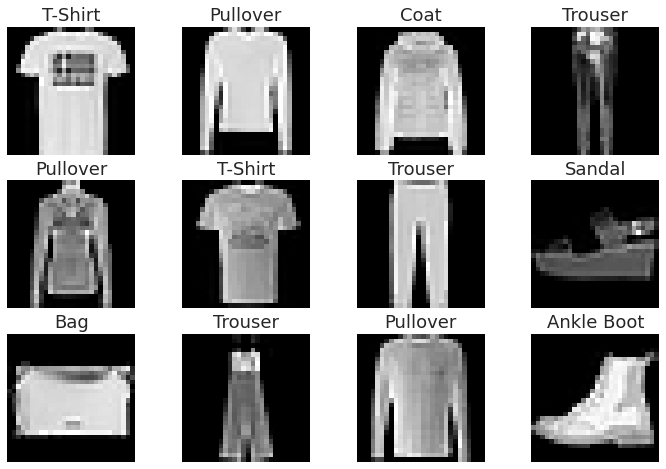

In [ ]:
## Definimos el diccionario de etiquetas
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

## Construimos el gráfico
figure = plt.figure(figsize=(12, 8))
cols, rows = 4, 3
for i in range(1, cols*rows + 1):
    ## Elegimos muestras al azar para visualizar
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(
        ## El método squeeze elimina dimensiones con un
        ## sólo elemento. En este caso, la dimensión C
        ## (channel). Esta dimensión es trivial porque
        ## las imágenes son en escala de grises. Si fuese
        ## RGB, tendríamos 3 canales, uno para cada color.
        img.squeeze(), 
        cmap="gray"
    )
plt.show()

Pasamos el ``Dataset`` como argumento a  ``DataLoader``. De esta manera encapsulamos el dataset en un iterable que soporta varias operaciones útiles, como trabajar por batch, hacer sampling, paralelizar el cómputo, etc.

Elegimos un tamaño de batch de 64 ejemplos. Cada elemento que nos devuelva el iterable va a contener 64 ejemplos con sus atributos y sus etiquetas.

In [ ]:
batch_size = 64

## Creamos los data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Dimensiones de X [N, C, H, W]: ", X.shape)
    print("Dimensiones de y: ", y.shape, y.dtype)
    break

Dimensiones de X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Dimensiones de y:  torch.Size([64]) torch.int64


## **Creamos el modelo**
-------------------

Todos los modelos en ``pytorch`` se definen como subclases de una clase genérica llamada ``Module``.

Nuestro **primer modelo** será una red de tipo **perceptrón multicapa**, con dos capas ocultas y función de activación de tipo **Rectified Linear Unit (ReLU)**.

![picture](https://static.packt-cdn.com/products/9781786468574/graphics/B05474_04_05.jpg)


El segundo modelo será una **red convolucional profunda**, con la misma función de activación

![picture](https://miro.medium.com/max/2000/1*7K4ZTTfZb-hbjoADbisHAg.png)

Ejemplos de funciones de activación:

![picture](https://gblobscdn.gitbook.com/assets%2F-LvBP1svpACTB1R1x_U4%2F-LvNWUoWieQqaGmU_gl9%2F-LvO3qs2RImYjpBE8vln%2Factivation-functions3.jpg?alt=media&token=f96a3007-5888-43c3-a256-2dafadd5df7c)

In [ ]:
## Definimos el modelo
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()

        ## "Achatamos" la matriz de 28x28 píxeles, 
        ## transformandola en un vector de 784 elementos
        self.flatten = nn.Flatten()

        ## Definimos el perceptrón multicapa con las
        ## siguientes capas:
        ##
        ## Entrada:        784 neuronas
        ## 1º capa oculta: 512 neuronas
        ## 2º capa oculta: 512 neuronas
        ## Salida:         10  neuronas
        ##
        ## Entre capa y capa, utilizamos función de 
        ## activación ReLU
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 600),
            nn.ReLU(),
            nn.Linear(600, 120),
            nn.ReLU(),
            nn.Linear(120, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        ## Primera capa convolucional:
        ## construimos 32 canales usando filtros (kernels) de 3x3
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,            
                kernel_size=3,                                 
                padding=1,                  
            ),
            ## Aplicamos Batch Normalization como regularización
            nn.BatchNorm2d(32),  
            ## Aplicamos la función de activación               
            nn.ReLU(),    
            ## Reducimos la imagen con Max Pooling                  
            nn.MaxPool2d(kernel_size=2, stride=2),    
        )

        ## Segunda capa convolucional:
        ## construimos 64 canales usando filtros (kernels) de 3x3
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=64,            
                kernel_size=3,                               
                padding=0
            ),    
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),                
        )

        ## "Achatamos" la salida de la última capa, de 64 canales 
        ## de tamaño 6x6, transformandola en un vector de 64*6*6 elementos
        self.flatten = nn.Flatten()

        ## Después de las capas convoulucionales,
        ## agregamos algunas capas densas. La última, de 10
        ## neurnonas, es nuestra capa de salida
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64 * 6 * 6, 600),
            nn.Dropout(0.25), 
            nn.ReLU(),
            nn.Linear(600, 120),
            nn.Dropout(0.25), ## Regularizamos con dropout después de cada capa
            nn.ReLU(),
            nn.Linear(120, 10),
            nn.Dropout(0.25), 
            nn.ReLU() 
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)     
        x = self.linear_relu_stack(x)
        return x

## Creamos una instancia de nuestro modelo
## (un objeto de la clase correspondiente)
model = MultiLayerPerceptron()
#model = CNN()

## "enviamos" el modelo a la GPU o a la CPU, 
## según esté disponible
model.to(device)

print(model)

MultiLayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
    (5): ReLU()
  )
)


## **Entrenamiento del modelo**
-----------------------------

Para entrenar el modelo, necesitamos definir una ``función error`` (loss function) y un ``optimizador`` (el algoritmo que intentará minimizar el error)

La función de costo que elegimos es la *Cross Entropy*, la cual combina dos pasos. Primero calcula la función *SoftMax* sobre la capa de salida, 

$$
\text{S}(x_i) = \dfrac{e^{x_i}}{\sum_j e^{x_j}}
$$

Luego, aplica al resultado la función *Negative Log-Likelihood loss*,

$$
\text{NLL}(x) = \sum_{i\text{ correctos}}-\log (x_i).
$$

Es decir, la cross entropy es igual a

$$
\text{CE}(x) = \sum_{i\text{ correctos}}-\log \left(\dfrac{e^{x_i}}{\sum_j e^{x_j}}\right).
$$

Veamos una ilustración sobre cómo funciona esta función error. Para más detalle, ver este [link](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/)

![picture](https://i.imgur.com/hU252jE.jpg)

In [ ]:
## Definimos la función error o "loss"
loss_fn = nn.CrossEntropyLoss()
loss_fn_name = 'CrossEntropy'

## Definimos el optimizador
learning_rate = 1e-2 
momentum = 0.5
sgd_optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    momentum=momentum
)
#
learning_rate = 0.001
adam_optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
)

## Para la red Feed-Forward elegimos este
optimizer = sgd_optimizer

## Para la CNN funciona mejor este
#optimizer = adam_optimizer

Para cada ciclo de entrenamiento, el modelo hace predicciones sobre el conjunto de entrenamiento, el cual se presenta en lotes (batchs), y hace *backpropagation* del error obtenido para ajustar los parámetros.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Entrena el modelo una época.
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        batch_size = X.shape[0]
        
        ## Calculamos el error en la predicción
        pred = model(X)
        true = y
        loss = loss_fn(pred, true)

        ## Ajustamos los pesos haciendo backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            train_loss = loss.item() / batch_size
            current = batch * batch_size
            print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")
        

También evaluamos el desempeño del modelo con respecto al conjunto de validación para asegurarnos de que esté aprendiendo.


In [ ]:
def test(dataloader, model, loss_fn, verbose=True):
    """
    Evalúa el modelo sobre los datos presentados en el parámetro "dataloader",
    y calcula las métricas correspondientes.
    """
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    accuracy = 100*correct
    if verbose:
      print(f"Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f}")

    return test_loss, accuracy

El proceso de entrenamiento se lleva a cabo en iteraciones llamadas épocas. Durante cada época, el modelo ajusta los parámetros para mejorar la predicción.

Imprimimos la precisión del modelo y la loss para cada época. Lo ideal es que la predicción aumente y que la loss disminuya con cada época.

In [ ]:
epochs = 50
train_losses = []
test_losses = []
train_acc_values = []
test_acc_values = []
for epoch in range(1, epochs+1):
    print(f'Época {epoch}')
    ## Entreno una época del modelo
    train(train_dataloader, model, loss_fn, optimizer)

    ## Evaluo sobre el consjunto de entrenamiento
    print()
    print('Train performance:')
    train_loss, train_acc = test(train_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    train_acc_values.append(train_acc)

    ## Evaluo sobre el conjunto de evaluación
    print('Test performance:')
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)
    test_acc_values.append(test_acc)
    print('-------------------------------------')
    print()

print("Done!")

Época 1
loss: 0.036022  [    0/60000]
loss: 0.033657  [ 6400/60000]
loss: 0.028122  [12800/60000]
loss: 0.026980  [19200/60000]
loss: 0.025052  [25600/60000]
loss: 0.025397  [32000/60000]
loss: 0.023595  [38400/60000]
loss: 0.023227  [44800/60000]
loss: 0.021614  [51200/60000]
loss: 0.025652  [57600/60000]

Train performance:
Accuracy: 57.20%, Avg loss: 0.020466
Test performance:
Accuracy: 56.48%, Avg loss: 0.020874
-------------------------------------

Época 2
loss: 0.018753  [    0/60000]
loss: 0.019881  [ 6400/60000]
loss: 0.016664  [12800/60000]
loss: 0.020973  [19200/60000]
loss: 0.020313  [25600/60000]
loss: 0.020823  [32000/60000]
loss: 0.020359  [38400/60000]
loss: 0.020874  [44800/60000]
loss: 0.018892  [51200/60000]
loss: 0.023186  [57600/60000]

Train performance:
Accuracy: 59.68%, Avg loss: 0.017738
Test performance:
Accuracy: 58.78%, Avg loss: 0.018237
-------------------------------------

Época 3
loss: 0.015300  [    0/60000]
loss: 0.017120  [ 6400/60000]
loss: 0.014643

## **Guardamos el modelo**
---------------------

Una forma estándar de guardar el modelo es "serializar" el diccionario con el estado interno del mismo, el cual contiene los parámetros del modelo.

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## **Cargamos un modelo guardado**
----------------------------

Para cargar un modelo almacenado, tenemos que recrear la estructura del modelo (definir una nueva instancia de nuestra clase) y cargar el diccionario con el estado interno (los parámetros).

In [ ]:
model = MultiLayerPerceptron().to(device)
#model = CNN().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## **Ovservamos las predicciones**
------------------------------

In [ ]:
def plot_img(data, idx):
    """
    Grafica un ejemplo
    """
    figure = plt.figure(figsize=(4, 4))
    img, label = data[idx]
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

def show_prediction(example):
    """
    Muestra la predicción para un ejemplo
    """
    model.eval()
    x, y = test_data[example][0], test_data[example][1]
    with torch.no_grad():
        pred = model(x.unsqueeze(1).to(device))
    sorted = pred.sort()
    values = softmax(sorted.values[0], dim=-1)
    indices = sorted.indices[0]
    print(
        f'Etiqueta correcta: {labels_map[y]}', 
        end='\n----------------\n'
    )
    print('Etiqueta     Probabilidad')
    for v, idx in list(zip(values,indices))[::-1]:
        label_pred = labels_map[idx.item()]
        print(f'{label_pred:13}{v.item():.5f}')

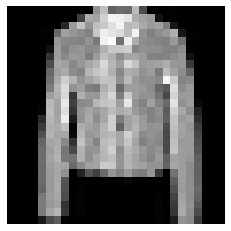

Etiqueta correcta: Coat
----------------
Etiqueta     Probabilidad
Coat         0.96939
Shirt        0.01754
Pullover     0.01044
Ankle Boot   0.00038
Sandal       0.00038
Bag          0.00038
Dress        0.00038
Trouser      0.00038
Sneaker      0.00038
T-Shirt      0.00038


In [ ]:
example = 10
plot_img(test_data, example)
show_prediction(example)

## **Analizamos el proceso de aprendizaje**

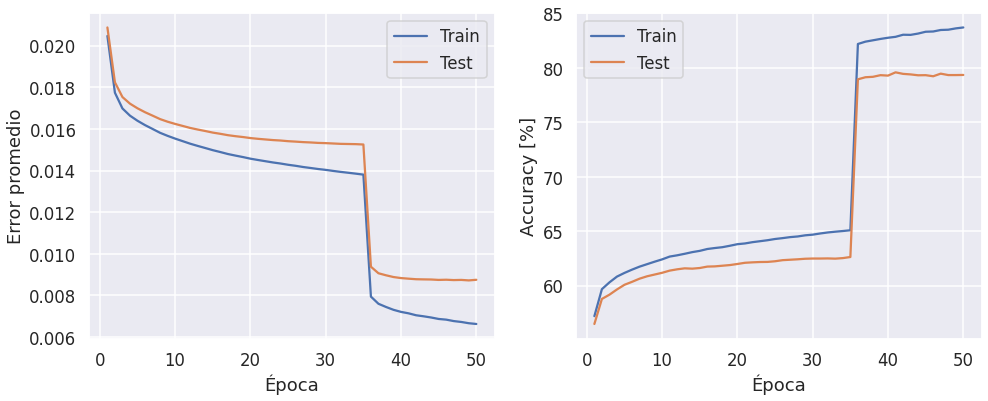

In [ ]:
X = range(1, len(train_losses)+1)

fig, axes = plt.subplots(figsize=(16, 6), ncols=2)
ax = axes[0]
ax.set_xlabel('Época')
ax.set_ylabel('Error promedio')
ax.plot(X, train_losses, label='Train')
ax.plot(X, test_losses, label='Test')
ax.legend()

ax = axes[1]
ax.set_xlabel('Época')
ax.set_ylabel('Accuracy [%]')
ax.plot(X, train_acc_values, label='Train')
ax.plot(X, test_acc_values, label='Test')
ax.legend()
plt.show()